## Corrputions for image of `any` size

The original ImageNet-C dataset preprocess images and crop them to 224x224. This notebook shows how to corrupt images of any size.

In [1]:
import ctypes
import os
import os.path
import time
from io import BytesIO

import cv2
import numpy as np
import skimage as sk
import torch
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as trn
import wand.color as WandColor
from PIL import Image
from PIL import Image as PILImage
from scipy.ndimage import zoom as scizoom
from scipy.ndimage.interpolation import map_coordinates
from skimage.filters import gaussian
from wand.api import library as wandlibrary
from wand.image import Image as WandImage

/tmp/ipykernel_2922341/461056419.py:23: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates


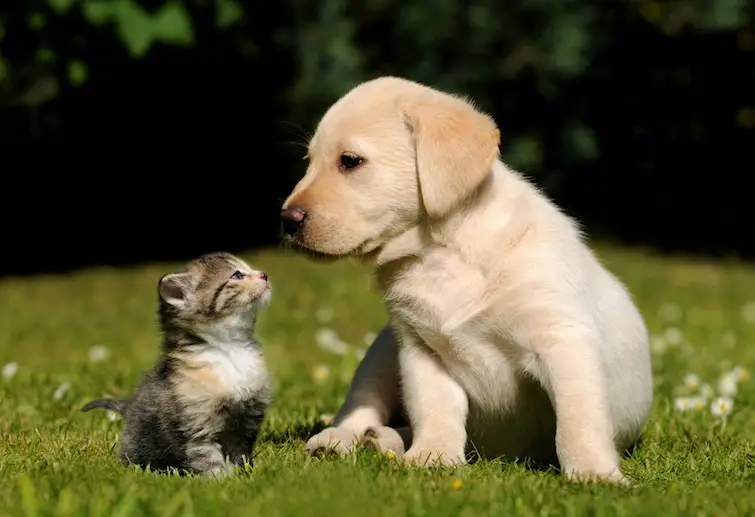

In [4]:
sample_image = Image.open("test.jpg")
sample_image

### `brightness`

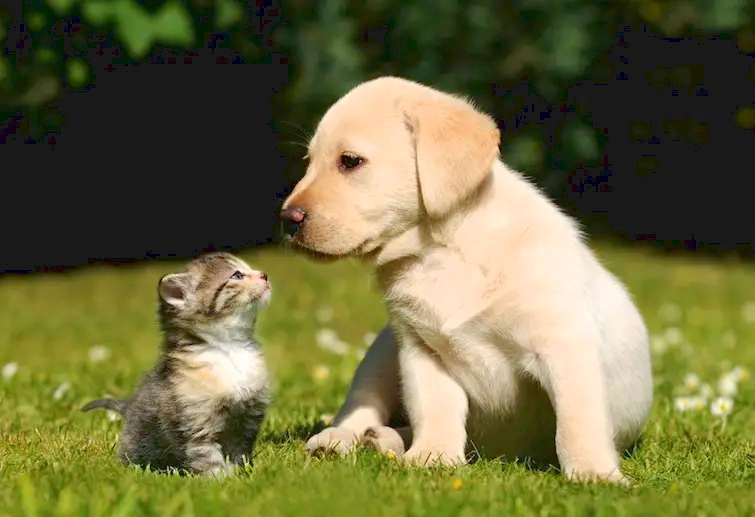

In [11]:
def brightness(x, severity=1):
    c = [0.1, 0.2, 0.3, 0.4, 0.5][severity - 1]

    x = np.array(x) / 255.0
    x = sk.color.rgb2hsv(x)
    x[:, :, 2] = np.clip(x[:, :, 2] + c, 0, 1)
    x = sk.color.hsv2rgb(x)

    return np.clip(x, 0, 1) * 255


Image.fromarray(brightness(sample_image, 1).astype(np.uint8))

### `impulse_noise`

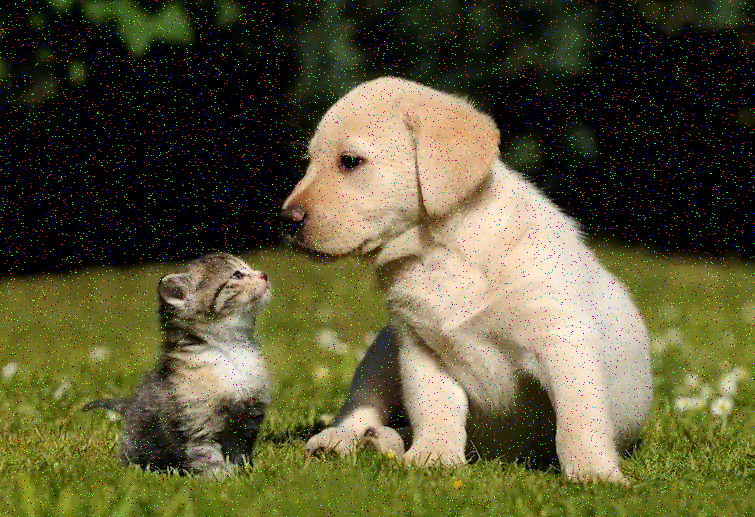

In [12]:
def impulse_noise(x, severity=1):
    c = [0.03, 0.06, 0.09, 0.17, 0.27][severity - 1]

    x = sk.util.random_noise(np.array(x) / 255.0, mode="s&p", amount=c)
    return np.clip(x, 0, 1) * 255


Image.fromarray(impulse_noise(sample_image, 1).astype(np.uint8))

### `zoom_blur`

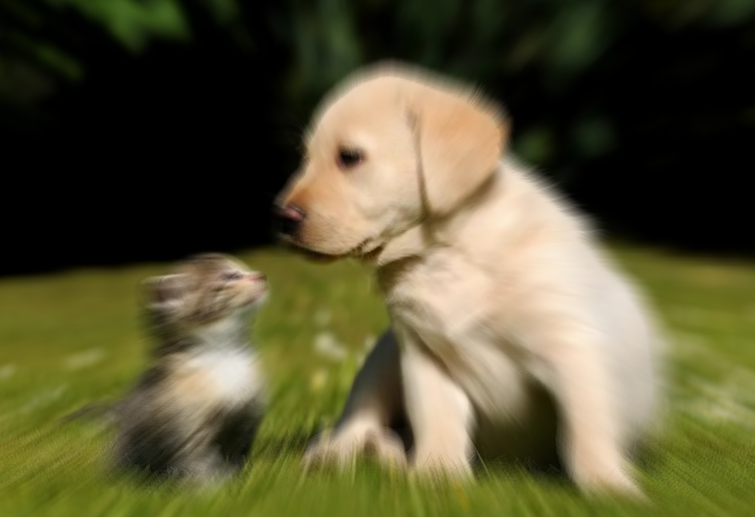

In [6]:
def clipped_zoom(img, zoom_factor):
    h, w = img.shape[:2]

    # Calculate the new height and width for the zoomed image
    zoomed_h = int(np.ceil(h / zoom_factor))
    zoomed_w = int(np.ceil(w / zoom_factor))

    # Calculate the top and left offsets for cropping
    top = (h - zoomed_h) // 2
    left = (w - zoomed_w) // 2

    # Crop and zoom the image
    img = scizoom(
        img[top : top + zoomed_h, left : left + zoomed_w],
        (zoom_factor, zoom_factor, 1),
        order=1,
    )

    # Calculate the trim offsets for the final image
    trim_top = (img.shape[0] - h) // 2
    trim_left = (img.shape[1] - w) // 2

    return img[trim_top : trim_top + h, trim_left : trim_left + w]


def zoom_blur(x, severity=1):
    c = [
        np.arange(1, 1.11, 0.01),
        np.arange(1, 1.16, 0.01),
        np.arange(1, 1.21, 0.02),
        np.arange(1, 1.26, 0.02),
        np.arange(1, 1.31, 0.03),
    ][severity - 1]

    x = (np.array(x) / 255.0).astype(np.float32)
    out = np.zeros_like(x)
    for zoom_factor in c:
        out += clipped_zoom(x, zoom_factor)

    x = (x + out) / (len(c) + 1)
    return np.clip(x, 0, 1) * 255


Image.fromarray(zoom_blur(sample_image, 1).astype(np.uint8))

### `snow`

/tmp/ipykernel_2922341/3224104374.py:26: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  snow_layer = cv2.imdecode(np.fromstring(snow_layer.make_blob(), np.uint8),


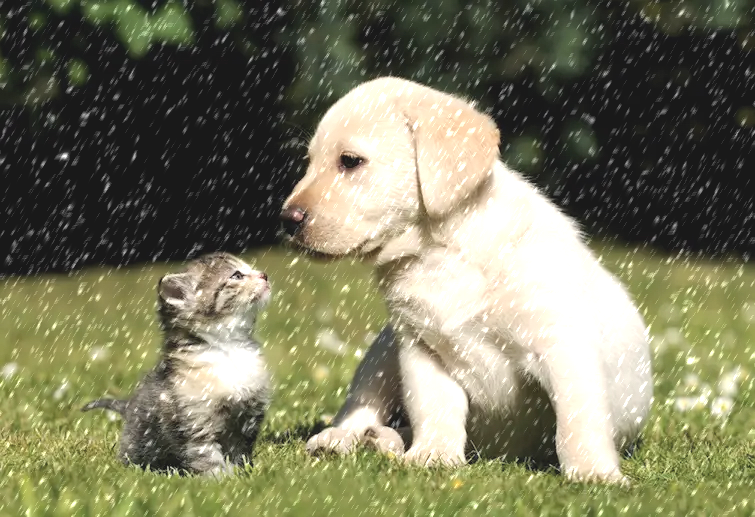

In [8]:
class MotionImage(WandImage):
    def motion_blur(self, radius=0.0, sigma=0.0, angle=0.0):
        wandlibrary.MagickMotionBlurImage(self.wand, radius, sigma, angle)


def snow(x, severity=1):
    c = [
        (0.1, 0.3, 3, 0.5, 10, 4, 0.8),
        (0.2, 0.3, 2, 0.5, 12, 4, 0.7),
        (0.55, 0.3, 4, 0.9, 12, 8, 0.7),
        (0.55, 0.3, 4.5, 0.85, 12, 8, 0.65),
        (0.55, 0.3, 2.5, 0.85, 12, 12, 0.55),
    ][severity - 1]

    x = np.array(x, dtype=np.float32) / 255.0
    snow_layer = np.random.normal(
        size=x.shape[:2], loc=c[0], scale=c[1]
    )  # [:2] for monochrome

    snow_layer = clipped_zoom(snow_layer[..., np.newaxis], c[2])
    snow_layer[snow_layer < c[3]] = 0

    snow_layer = PILImage.fromarray(
        (np.clip(snow_layer.squeeze(), 0, 1) * 255).astype(np.uint8), mode="L"
    )
    output = BytesIO()
    snow_layer.save(output, format="PNG")
    snow_layer = MotionImage(blob=output.getvalue())

    snow_layer.motion_blur(radius=c[4], sigma=c[5], angle=np.random.uniform(-135, -45))

    snow_layer = (
        cv2.imdecode(
            np.fromstring(snow_layer.make_blob(), np.uint8), cv2.IMREAD_UNCHANGED
        )
        / 255.0
    )
    snow_layer = snow_layer[..., np.newaxis]

    height, width, _ = x.shape
    x = c[6] * x + (1 - c[6]) * np.maximum(
        x, cv2.cvtColor(x, cv2.COLOR_RGB2GRAY).reshape(height, width, 1) * 1.5 + 0.5
    )
    return np.clip(x + snow_layer + np.rot90(snow_layer, k=2), 0, 1) * 255


Image.fromarray(snow(sample_image, 1).astype(np.uint8))

### `frost`

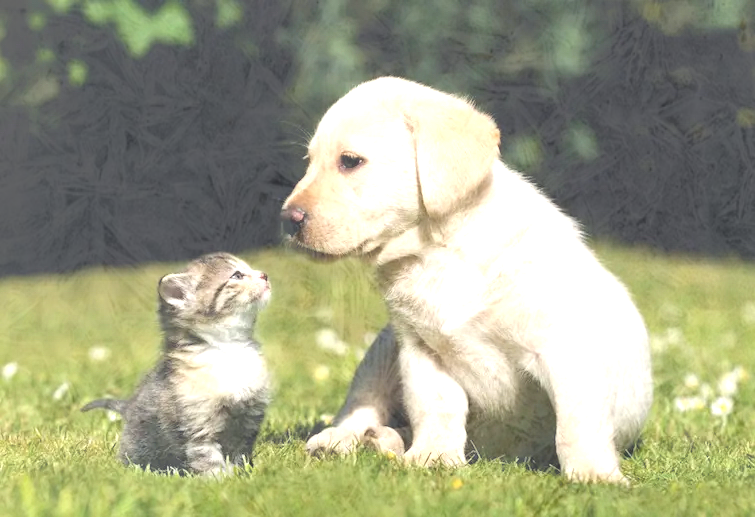

In [9]:
def frost(x, severity=1):
    c = [(1, 0.4), (0.8, 0.6), (0.7, 0.7), (0.65, 0.7), (0.6, 0.75)][severity - 1]
    idx = np.random.randint(5)
    filename = [
        "./ImageNet-C/create_c/frost1.png",
        "./ImageNet-C/create_c/frost2.png",
        "./ImageNet-C/create_c/frost3.png",
        "./ImageNet-C/create_c/frost4.jpg",
        "./ImageNet-C/create_c/frost5.jpg",
        "./ImageNet-C/create_c/frost6.jpg",
    ][idx]
    frost = cv2.imread(filename)

    # Convert the input image to a NumPy array
    x_array = np.array(x)

    # Resize frost image to match input image size
    frost_resized = cv2.resize(
        frost, (x_array.shape[1], x_array.shape[0]), interpolation=cv2.INTER_LINEAR
    )

    # Convert to RGB
    frost_resized = frost_resized[..., [2, 1, 0]]

    return np.clip(c[0] * x_array + c[1] * frost_resized, 0, 255)


Image.fromarray(frost(sample_image, 1).astype(np.uint8))

### `fog`

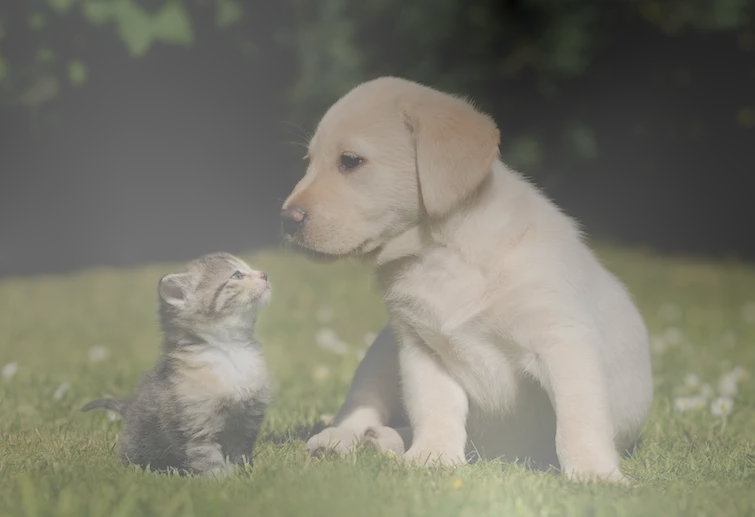

In [10]:
def plasma_fractal(mapsize=256, wibbledecay=3):
    """
    Generate a heightmap using diamond-square algorithm.
    Return square 2d array, side length 'mapsize', of floats in range 0-255.
    'mapsize' must be a power of two.
    """
    assert mapsize & (mapsize - 1) == 0
    maparray = np.empty((mapsize, mapsize), dtype=np.float_)
    maparray[0, 0] = 0
    stepsize = mapsize
    wibble = 100

    def wibbledmean(array):
        return array / 4 + wibble * np.random.uniform(-wibble, wibble, array.shape)

    def fillsquares():
        """For each square of points stepsize apart,
        calculate middle value as mean of points + wibble"""
        cornerref = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        squareaccum = cornerref + np.roll(cornerref, shift=-1, axis=0)
        squareaccum += np.roll(squareaccum, shift=-1, axis=1)
        maparray[
            stepsize // 2 : mapsize : stepsize, stepsize // 2 : mapsize : stepsize
        ] = wibbledmean(squareaccum)

    def filldiamonds():
        """For each diamond of points stepsize apart,
        calculate middle value as mean of points + wibble"""
        mapsize = maparray.shape[0]
        drgrid = maparray[
            stepsize // 2 : mapsize : stepsize, stepsize // 2 : mapsize : stepsize
        ]
        ulgrid = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        ldrsum = drgrid + np.roll(drgrid, 1, axis=0)
        lulsum = ulgrid + np.roll(ulgrid, -1, axis=1)
        ltsum = ldrsum + lulsum
        maparray[0:mapsize:stepsize, stepsize // 2 : mapsize : stepsize] = wibbledmean(
            ltsum
        )
        tdrsum = drgrid + np.roll(drgrid, 1, axis=1)
        tulsum = ulgrid + np.roll(ulgrid, -1, axis=0)
        ttsum = tdrsum + tulsum
        maparray[stepsize // 2 : mapsize : stepsize, 0:mapsize:stepsize] = wibbledmean(
            ttsum
        )

    while stepsize >= 2:
        fillsquares()
        filldiamonds()
        stepsize //= 2
        wibble /= wibbledecay

    maparray -= maparray.min()
    return maparray / maparray.max()


def fog(x, severity=1):
    c = [(1.5, 2), (2, 2), (2.5, 1.7), (2.5, 1.5), (3, 1.4)][severity - 1]

    x = np.array(x) / 255.0
    max_val = x.max()

    # Get the input image size
    img_height, img_width, _ = x.shape

    # Generate plasma fractal with the same size as the input image
    fractal = plasma_fractal(
        wibbledecay=c[1], mapsize=2 ** int(np.ceil(np.log2(max(img_height, img_width))))
    )

    # Crop the fractal to match the input image size
    cropped_fractal = fractal[:img_height, :img_width][..., np.newaxis]

    x += c[0] * cropped_fractal
    return np.clip(x * max_val / (max_val + c[0]), 0, 1) * 255


Image.fromarray(fog(sample_image, 1).astype(np.uint8))